In [1]:
import subprocess
import numpy as np


from robopianist.robopianist.suite.tasks import self_actuated_piano
from robopianist.robopianist.suite.tasks import piano_with_shadow_hands
from dm_env_wrappers import CanonicalSpecWrapper
from robopianist.robopianist.wrappers import PianoSoundVideoWrapper
from robopianist.robopianist import music
from mujoco_utils import composer_utils
import dm_env

%load_ext autoreload
%autoreload 2

#   The command to quit VLC after finished
QUIT_VLC_COMMAND = 'vlc://quit'
def play_video(video_path:str):
    #   Using cvlc, for not interfacing
    subprocess.Popen(['cvlc', video_path, QUIT_VLC_COMMAND])

ImportError: cannot import name '_PROJECT_ROOT' from 'robopianist' (unknown location)

In [ ]:
import os
proto_dir = '/home/ultra/work/oeipaca/robopianist/robopianist/music/data/pig_single_finger'
path_list = os.listdir( proto_dir)

midi_file = os.path.join( proto_dir, path_list[ 120 ] )
print( midi_file )

/home/ultra/work/oeipaca/robopianist/robopianist/music/data/pig_single_finger/etude_op_25_no_11-1.proto


In [19]:
midi_file

'/home/ultra/work/oeipaca/robopianist/robopianist/music/data/pig_single_finger/etude_op_10_no_3-1.proto'

In [18]:
midi_file = '/home/ultra/work/oeipaca/robopianist/robopianist/music/data/pig_single_finger/etude_op_10_no_3-1.proto'
midi = music.load( midi_file )
midi = midi.trim_silence()
midi.play()

ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


### Self-actuated piano task

In [15]:
task = self_actuated_piano.SelfActuatedPiano(
    midi=music.load("TwinkleTwinkleRousseau"),
    change_color_on_activation=True,
    trim_silence=True,
    control_timestep=0.01,
)

env = composer_utils.Environment(
    recompile_physics=False, task=task, strip_singleton_obs_buffer_dim=True
)

env = PianoSoundVideoWrapper(
    env,
    record_every=1,
    camera_id="piano/back",
    record_dir=".",
)

In [16]:
action_spec = env.action_spec()
min_ctrl = action_spec.minimum
max_ctrl = action_spec.maximum
print(f"Action dimension: {action_spec.shape}")

Action dimension: (89,)


In [17]:
print("Observables:")
timestep = env.reset()
dim = 0
for k, v in timestep.observation.items():
    print(f"\t{k}: {v.shape} {v.dtype}")
    dim += np.prod(v.shape)
print(f"Observation dimension: {dim}")

Observables:
	goal: (89,) float64
	piano/activation: (88,) float64
	piano/sustain_activation: (1,) float64
Observation dimension: 178


In [18]:
class Oracle:
    def __call__(self, timestep: dm_env.TimeStep) -> np.ndarray:
        if timestep.reward is not None:
            assert timestep.reward == 0
        # Only grab the next timestep's goal state.
        goal = timestep.observation["goal"][: task.piano.n_keys]
        key_idxs = np.flatnonzero(goal)
        # For goal keys that should be pressed, set the action to the maximum
        # actuator value. For goal keys that should be released, set the action to
        # the minimum actuator value.
        action = min_ctrl.copy()
        action[key_idxs] = max_ctrl[key_idxs]
        # Grab the sustain pedal action.
        action[-1] = timestep.observation["goal"][-1]
        return action

In [19]:
policy = Oracle()

timestep = env.reset()
while not timestep.last():
    action = policy(timestep)
    timestep = env.step(action)

00002.mp4


In [8]:
play_video( env.latest_filename )

### Piano with shadow hand

In [27]:
task = piano_with_shadow_hands.PianoWithShadowHands(
    change_color_on_activation=True,
    midi=music.load("TwinkleTwinkleRousseau"),
    trim_silence=True,
    control_timestep=0.05,
    gravity_compensation=True,
    primitive_fingertip_collisions=False,
    reduced_action_space=False,
    n_steps_lookahead=10,
    disable_fingering_reward=False,
    disable_forearm_reward=False,
    disable_colorization=False,
    disable_hand_collisions=False,
    attachment_yaw=0.0,
)

env = composer_utils.Environment(
    task=task, strip_singleton_obs_buffer_dim=True, recompile_physics=False
)


env = PianoSoundVideoWrapper(
    env,
    record_every=10,
    camera_id="piano/back",
    record_dir=".",
)

env = CanonicalSpecWrapper(env)

In [28]:
class Policy:
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self._idx = 0
        self._actions = np.load("/home/ultra/work/oeipaca/robopianist/examples/twinkle_twinkle_actions.npy")

    def __call__(self, timestep: dm_env.TimeStep) -> np.ndarray:
        del timestep  # Unused.
        actions = self._actions[self._idx]
        self._idx += 1
        return actions

##### There are some bug when the number of recording is not every episode 

In [29]:
# for i in range( 20 ):
policy = Policy()
timestep = env.reset()

while not timestep.last():
    action = policy(timestep)
    timestep = env.step(action)

    # num_steps, rewards, discount, obs = timestep
    # print( 'Step: {}, discout {}'.format( num_steps, discount ))

In [30]:
num_steps, rewards, discount, obs = timestep
print( f'Observation\n' )

for key, val in obs.items():

    print( f'    { key } with shape {val.shape}\n{val}\n' )

Observation

    goal with shape (979,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

In [31]:
obs[ 'goal' ].shape[ 0 ]

979

In [32]:
play_video( env.latest_filename )

ValueError: No video has been recorded yet.

##### Observe the action space

- I will vary each action component to the maximum value which is 1..

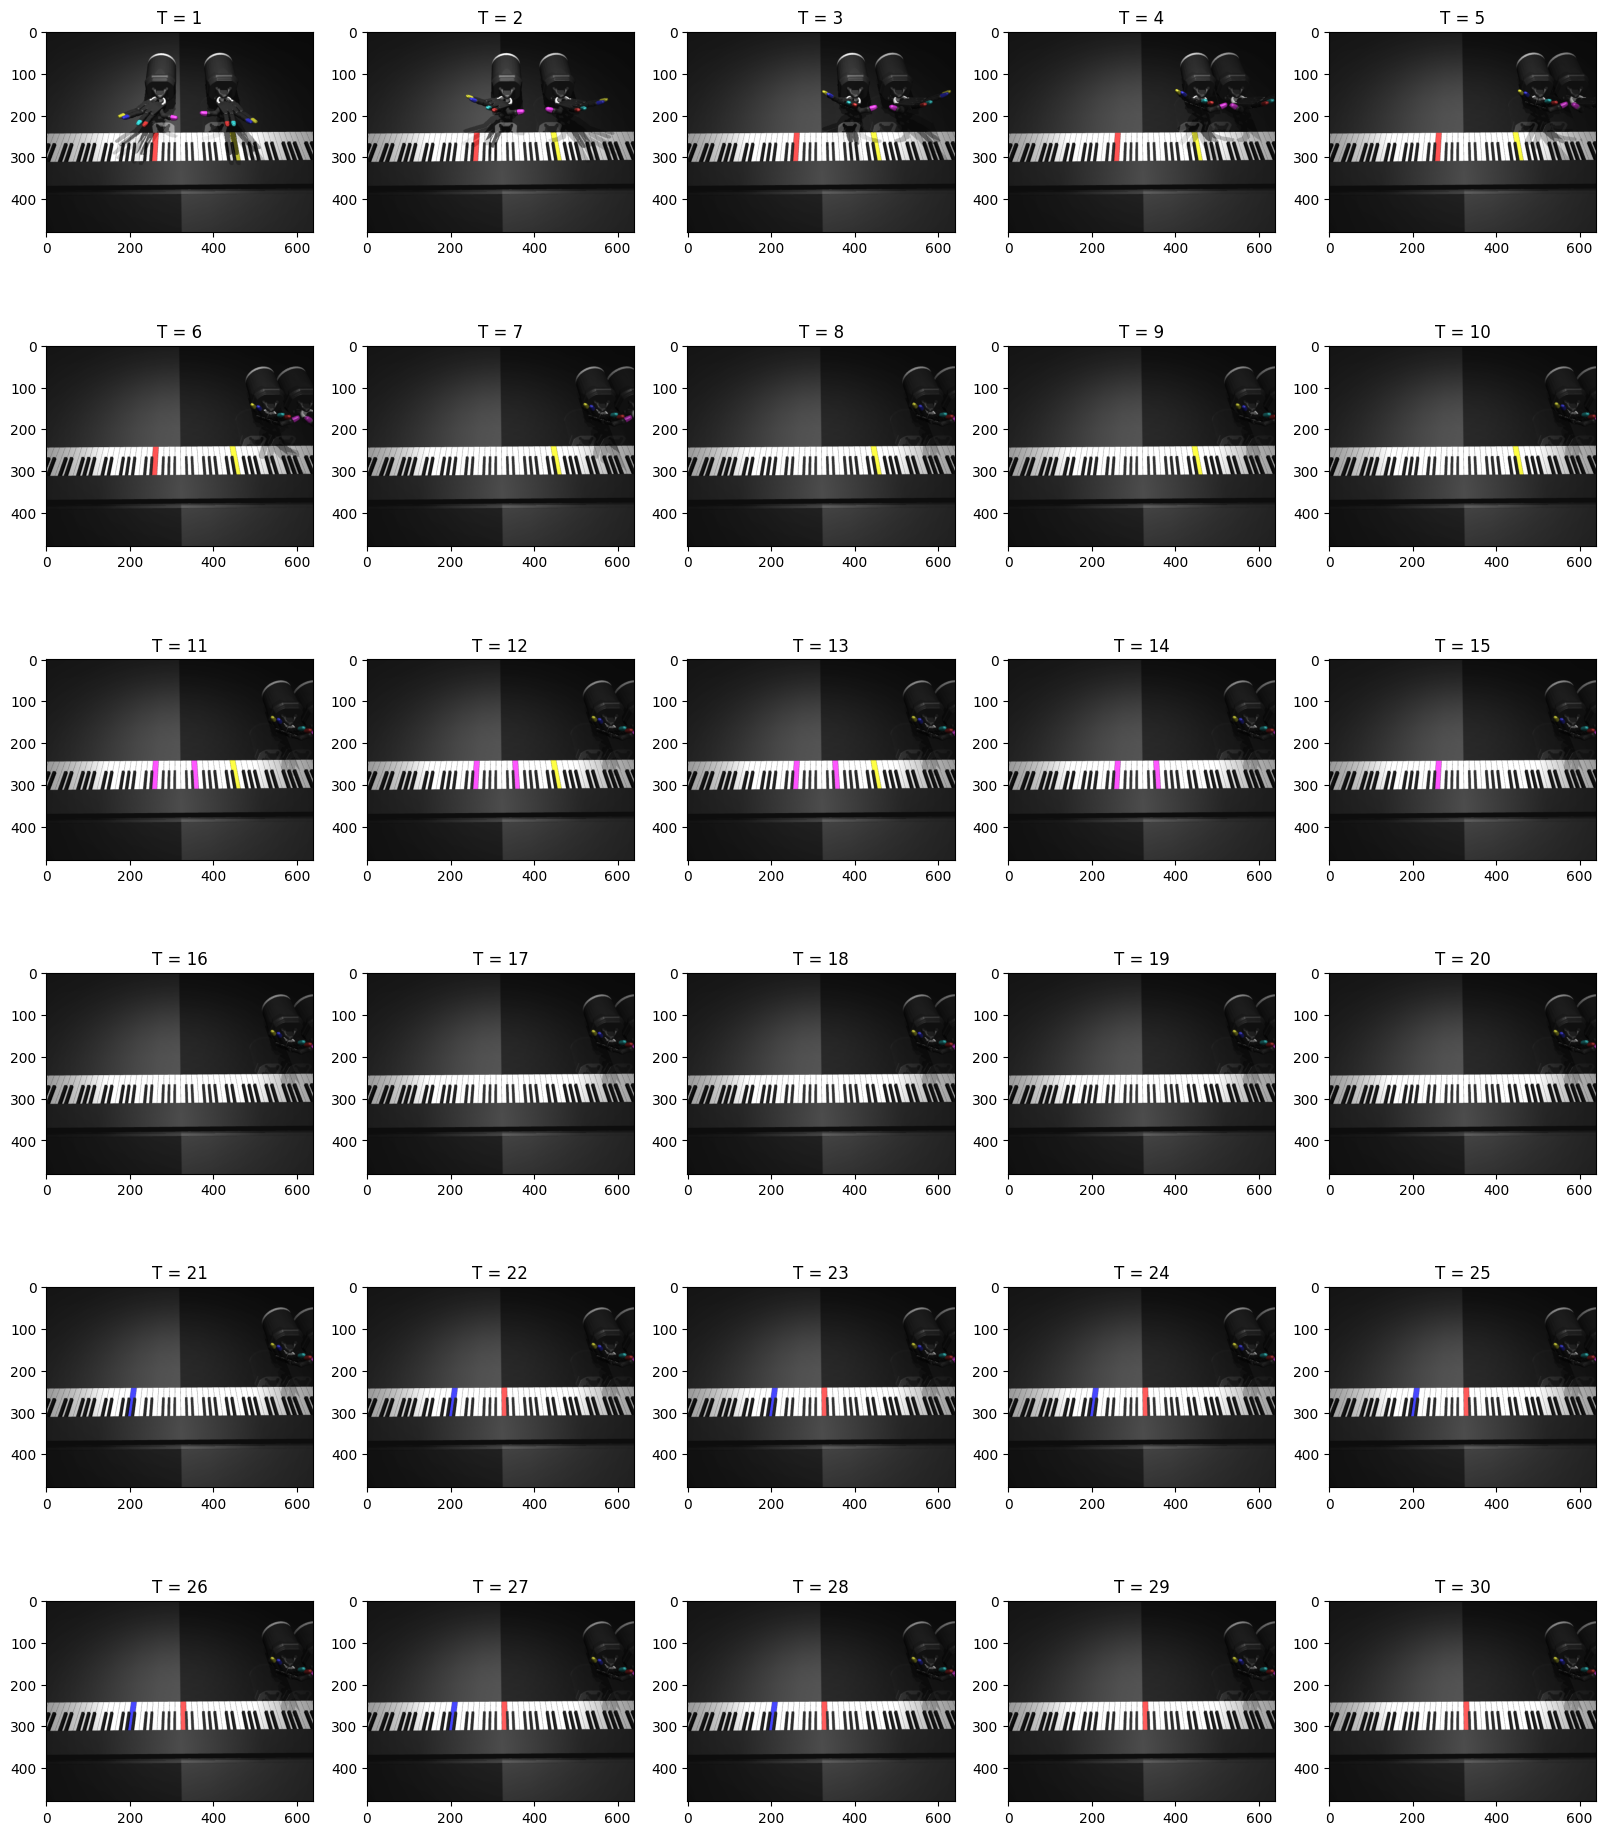

In [35]:
import matplotlib.pyplot as plt

policy = Policy()
timestep = env.reset()

t = 0

#   Ratio 5:9
plt.figure( figsize=( 20, 36 ) )

while not timestep.last():
    plt.subplot( 9, 5, ( t + 1 ) )
    # action = policy( timestep )
    action = np.zeros( shape=( 45, ) ) - 1.5

    # action[ 20 ] = -1

    timestep = env.step( action )

    num_steps, rewards, discount, obs = timestep

    t += 1
    plt.title( f'T = { t }' )
    plt.imshow( env._render_frame( timestep ) )

    if t >= 30:
        break

plt.show()

In [36]:
num_steps, rewards, discount, obs = timestep
print( f'Observation\n' )

for key, val in obs.items():

    print( f'    { key } with shape {val.shape}\n{val}\n' )

Observation

    goal with shape (979,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0